In [9]:
import os
import pandas as pd

preprocessed_dir = 'Preprocessed'
columns_dict = {}

for fname in os.listdir(preprocessed_dir):
    if fname.endswith('.csv'):
        fpath = os.path.join(preprocessed_dir, fname)
        try:
            df = pd.read_csv(fpath, nrows=1)
            columns_dict[fname] = list(df.columns)
        except Exception as e:
            columns_dict[fname] = f'Hata: {e}'

for fname, cols in columns_dict.items():
    print(f"{fname} sütunları:")
    print(cols)
    print("-"*40)


FileNotFoundError: [WinError 3] Sistem belirtilen yolu bulamıyor: 'Preprocessed'

In [ ]:
# --- Ev Sekmesi: Kullanıcıdan model inputları al, otomatik bolus/bazal ata ve LSTM modelinden tahmin al ---

import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import pandas as pd

# Model inputlarını kullanıcıdan alıp tahmin yapan fonksiyon
# Sadece modelin istediği inputlar: 'carb_input', 'steps', 'calories', 'heart_rate'
def get_model_inputs_and_predict(model, scaler, look_back=12, columns_needed=None):
    if columns_needed is None:
        columns_needed = ['glucose', 'carb_input', 'bolus_volume_delivered', 'basal_rate', 'steps', 'calories', 'heart_rate']

    # Kullanıcıdan alınacak inputlar
    carb_input = widgets.BoundedFloatText(description='Karbonhidrat (g):', min=0, max=500, step=0.1)
    steps = widgets.BoundedIntText(description='Adım:', min=0, max=100000)
    calories = widgets.BoundedFloatText(description='Kalori:', min=0, max=10000, step=0.1)
    heart_rate = widgets.BoundedIntText(description='Nabız:', min=30, max=250)

    # Bolus ve bazal otomatik atanır (örnek: hayır seçilmiş gibi default)
    bolus_val = 0.038477
    bazal_val = 0.049675

    submit_btn = widgets.Button(description='Tahmin Et', button_style='success')
    out = widgets.Output()

    def on_submit(b):
        with out:
            clear_output()
            input_dict = {
                'glucose': np.nan,
                'carb_input': carb_input.value,
                'bolus_volume_delivered': bolus_val,
                'basal_rate': bazal_val,
                'steps': steps.value,
                'calories': calories.value,
                'heart_rate': heart_rate.value,
            }
            # Modelin look_back kadar veri beklediği için dummy veri ile doldur
            df_pred = pd.DataFrame([input_dict]*look_back)
            df_pred.iloc[-1] = input_dict
            try:
                y_pred = predict_with_model(df_pred, model, scaler, look_back=look_back, columns_needed=columns_needed)
                display(pd.DataFrame([input_dict]))
                print(f"Kan şekeri tahmini: {y_pred:.3f} mg/dL")
            except Exception as e:
                print(f"Tahmin sırasında hata: {e}")

    submit_btn.on_click(on_submit)

    form = widgets.VBox([
        widgets.HTML('<h3>Model Girdileri</h3>'),
        carb_input, steps, calories, heart_rate,
        submit_btn, out
    ])
    display(form)

# Model ve scaler yüklenmiş olmalı:
try:
    get_model_inputs_and_predict(model2, scaler, look_back=12, columns_needed=['glucose', 'carb_input', 'bolus_volume_delivered', 'basal_rate', 'steps', 'calories', 'heart_rate'])
except NameError:
    print('Lütfen önce model2 ve scaler nesnelerini yükleyin!')


FileNotFoundError: [Errno 2] No such file or directory: 'Preprocessed/HUPA0001P.csv'

In [8]:
# Korelasyon matrisi ve ısı haritası
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasyon Matrisi Isı Haritası')
plt.show()

NameError: name 'df' is not defined

In [5]:
df.head(10)  # İlk 10 satırı göster

NameError: name 'df' is not defined

In [13]:
# LSTM ile zaman serisi tahmini ve performans değerlendirme
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Parametreler
test_start_date = '2018-07-01'  # Test verisi başlangıç tarihi (örnek)
look_back = 12  # Yukarıdaki ile aynı olmalı

# X ve y'nin indekslerini orijinal zamana bağlamak için zaman dizisi
all_times = df.index[look_back:]
all_times = pd.to_datetime(all_times)  # Ensure all_times is DatetimeIndex

# Eğitim ve test bölme
train_idx = all_times < pd.to_datetime(test_start_date)
test_idx = all_times >= pd.to_datetime(test_start_date)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Modeli oluştur
model = Sequential([
    LSTM(32, input_shape=(look_back, X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Eğit
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Tahmin
y_pred = model.predict(X_test)

# Normalize edilmiş değerleri orijinal ölçeğe döndür
# Sadece glucose sütunu için inverse transform
# scaler'ın orijinal df ile aynı sırada olması gerekir
glucose_col = df.columns.get_loc('glucose')

def inverse_transform_glucose(y_scaled):
    dummy = np.zeros((len(y_scaled), df.shape[1]))
    dummy[:, glucose_col] = y_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, glucose_col]

y_test_inv = inverse_transform_glucose(y_test)
y_pred_inv = inverse_transform_glucose(y_pred)

# Performans metrikleri
rmse = mean_squared_error(y_test_inv, y_pred_inv, squared=False)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Grafik
plt.figure(figsize=(15,5))
plt.plot(all_times[test_idx], y_test_inv, label='Gerçek Glikoz')
plt.plot(all_times[test_idx], y_pred_inv, label='Tahmin Glikoz')
plt.title('Gerçek vs Tahmin Glikoz Değerleri')
plt.xlabel('Zaman')
plt.ylabel('Glikoz (mg/dL)')
plt.legend()
plt.show()

Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0737
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0737
Epoch 2/20
 49/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056

c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0054
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 

ValueError: math domain error

In [14]:
# Test veri kümesinin boş olup olmadığını kontrol et
print('X_test shape:', X_test.shape)
print('X_train shape:', X_train.shape)
if X_test.shape[0] == 0:
    raise ValueError("Test veri kümesi boş! test_start_date parametresini kontrol edin.")

# EarlyStopping callback ekle
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modeli eğit (callback ile)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

X_test shape: (0, 12, 7)
X_train shape: (4084, 12, 7)


ValueError: Test veri kümesi boş! test_start_date parametresini kontrol edin.

Veri başlangıç tarihi: 2018-06-13 18:40:00
Veri bitiş tarihi: 2018-06-27 23:55:00
Otomatik test başlangıç tarihi: 2018-06-25 03:40:00
X_train shape: (3264, 12, 7)
X_test shape: (820, 12, 7)
Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0582 - val_loss: 0.0062
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0582 - val_loss: 0.0062
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━

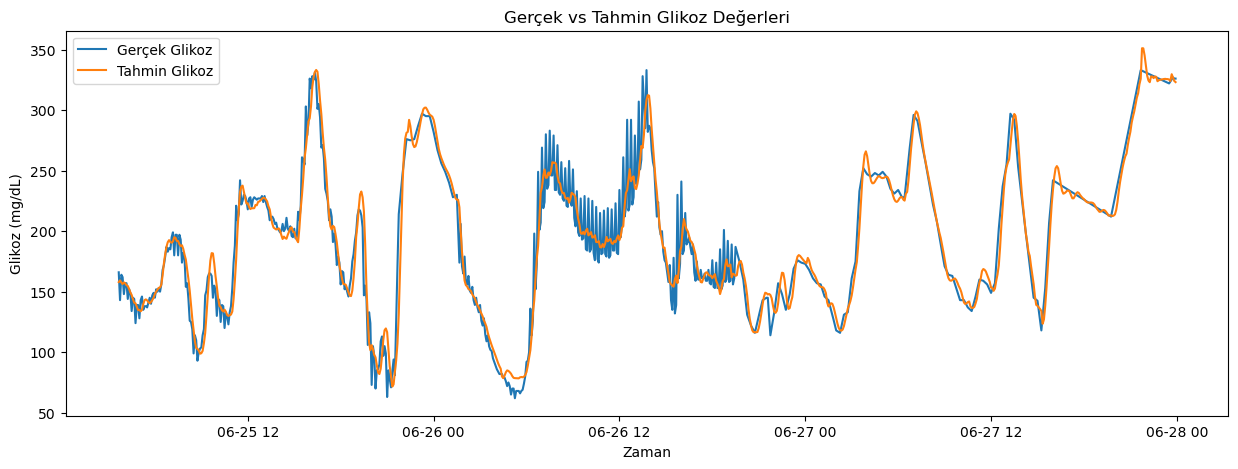

In [15]:
# Veri aralığını kontrol et ve otomatik test başlangıç tarihi belirle
print('Veri başlangıç tarihi:', df.index.min())
print('Veri bitiş tarihi:', df.index.max())

# Otomatik test başlangıç tarihi (verinin %80'i eğitim, %20'si test)
split_idx = int(len(df) * 0.8)
auto_test_start_date = df.index[split_idx]
print('Otomatik test başlangıç tarihi:', auto_test_start_date)

test_start_date = auto_test_start_date
all_times = df.index[look_back:]
train_idx = all_times < test_start_date
test_idx = all_times >= test_start_date

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
if X_test.shape[0] == 0:
    raise ValueError("Test veri kümesi hâlâ boş! Veri aralığını ve bölme oranını kontrol edin.")

# EarlyStopping callback ekle
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modeli oluştur ve eğit
model = Sequential([
    LSTM(32, input_shape=(look_back, X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Tahmin
y_pred = model.predict(X_test)

# Normalize edilmiş değerleri orijinal ölçeğe döndür
# Sadece glucose sütunu için inverse transform
glucose_col = df.columns.get_loc('glucose')
def inverse_transform_glucose(y_scaled):
    dummy = np.zeros((len(y_scaled), df.shape[1]))
    dummy[:, glucose_col] = y_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, glucose_col]

y_test_inv = inverse_transform_glucose(y_test)
y_pred_inv = inverse_transform_glucose(y_pred)

# Performans metrikleri (sklearn eski sürüm uyumlu)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Grafik
plt.figure(figsize=(15,5))
plt.plot(all_times[test_idx], y_test_inv, label='Gerçek Glikoz')
plt.plot(all_times[test_idx], y_pred_inv, label='Tahmin Glikoz')
plt.title('Gerçek vs Tahmin Glikoz Değerleri')
plt.xlabel('Zaman')
plt.ylabel('Glikoz (mg/dL)')
plt.legend()
plt.show()

In [17]:
# Performans metrikleri (sklearn eski sürüm uyumlu)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 14.65
MAE: 9.92


Epoch 1/30


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0404 - val_loss: 0.0059
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0404 - val_loss: 0.0059
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0085 - val_loss: 0.0058
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0085 - val_loss: 0.0058
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0042
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0042
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

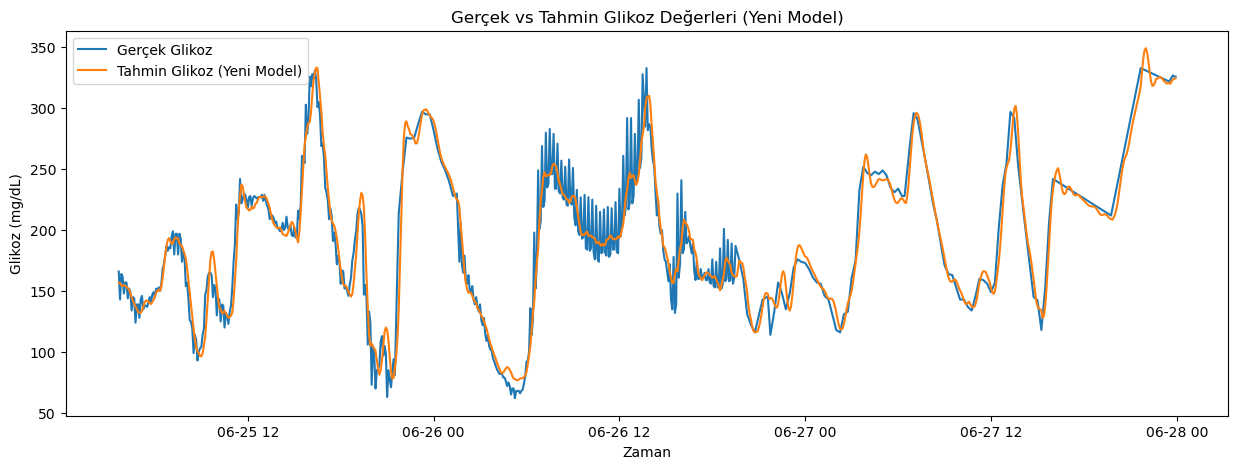

In [18]:
# Dropout ve daha fazla nöron içeren yeni LSTM modeli
from tensorflow.keras.layers import Dropout

# Modeli oluştur
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# EarlyStopping callback ekle
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Eğit
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Tahmin
y_pred = model.predict(X_test)

y_test_inv = inverse_transform_glucose(y_test)
y_pred_inv = inverse_transform_glucose(y_pred)

# Performans metrikleri
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'Yeni Model RMSE: {rmse:.2f}')
print(f'Yeni Model MAE: {mae:.2f}')

# Grafik
plt.figure(figsize=(15,5))
plt.plot(all_times[test_idx], y_test_inv, label='Gerçek Glikoz')
plt.plot(all_times[test_idx], y_pred_inv, label='Tahmin Glikoz (Yeni Model)')
plt.title('Gerçek vs Tahmin Glikoz Değerleri (Yeni Model)')
plt.xlabel('Zaman')
plt.ylabel('Glikoz (mg/dL)')
plt.legend()
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step - loss: 0.0195 - val_loss: 0.0028
Epoch 2/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step - loss: 0.0195 - val_loss: 0.0028
Epoch 2/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 3/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 256ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 3/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 4/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 4/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 5/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 5/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 6/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 6/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 7/40
102/102 ━━

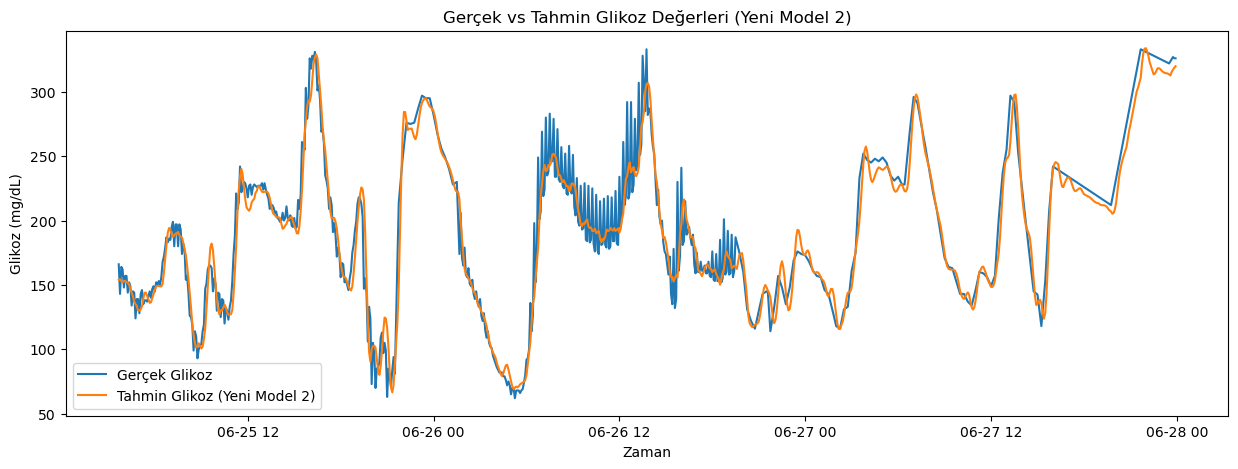

In [19]:
# EarlyStopping patience değeri artırılmış yeni bir LSTM modeli (Yeni Model 2)
from tensorflow.keras.layers import Dropout

model2 = Sequential([
    LSTM(512, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.3),
    LSTM(512),
    Dropout(0.3),
    Dense(1)
])
model2.compile(optimizer='adam', loss='mse')

# EarlyStopping patience artırıldı
from tensorflow.keras.callbacks import EarlyStopping

early_stop2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = model2.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop2],
    verbose=1
)

y_pred2 = model2.predict(X_test)

y_test_inv2 = inverse_transform_glucose(y_test)
y_pred_inv2 = inverse_transform_glucose(y_pred2)

rmse2 = np.sqrt(mean_squared_error(y_test_inv2, y_pred_inv2))
mae2 = mean_absolute_error(y_test_inv2, y_pred_inv2)
print(f'Yeni Model 2 RMSE: {rmse2:.2f}')
print(f'Yeni Model 2 MAE: {mae2:.2f}')

plt.figure(figsize=(15,5))
plt.plot(all_times[test_idx], y_test_inv2, label='Gerçek Glikoz')
plt.plot(all_times[test_idx], y_pred_inv2, label='Tahmin Glikoz (Yeni Model 2)')
plt.title('Gerçek vs Tahmin Glikoz Değerleri (Yeni Model 2)')
plt.xlabel('Zaman')
plt.ylabel('Glikoz (mg/dL)')
plt.legend()
plt.show()

In [34]:
# Modeli kaydetme ve yükleme, eksik değerleri KNN ile doldurup tahmin fonksiyonu (güncel, time kullanılmaz)
def save_model(model, scaler, path_prefix="lstm_model2"):
    import joblib
    import tensorflow as tf
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    model.save(f"{path_prefix}.h5")
    joblib.dump(scaler, f"{path_prefix}_scaler.pkl")
    print(f"Model ve scaler kaydedildi: {path_prefix}.h5, {path_prefix}_scaler.pkl")

def load_model_and_scaler(path_prefix="lstm_model2"):
    from tensorflow.keras.models import load_model
    import joblib
    import tensorflow as tf
    model = load_model(f"{path_prefix}.h5", compile=False)
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    scaler = joblib.load(f"{path_prefix}_scaler.pkl")
    return model, scaler

# Eksik değerleri KNN ile doldurup tahmin yapan fonksiyon (time sütunu kullanılmaz)
def predict_with_model(input_df, model, scaler, look_back=12, columns_needed=None):
    import numpy as np
    from sklearn.impute import KNNImputer
    import pandas as pd
    if columns_needed is None:
        columns_needed = ['glucose', 'carb_input', 'bolus_volume_delivered', 'basal_rate', 'steps', 'calories', 'heart_rate']
    df_pred = input_df.copy()
    # Sadece özellik sütunlarını al
    features_df = df_pred[columns_needed].copy()
    # KNN ile eksik değerleri doldur
    imputer = KNNImputer(n_neighbors=3)
    features_filled = imputer.fit_transform(features_df)
    # Ölçeklendir
    features_scaled = scaler.transform(features_filled)
    # look_back uzunluğunda veri olmalı
    if len(features_scaled) < look_back:
        raise ValueError(f"En az {look_back} satır veri gerekli!")
    X_pred = np.array([features_scaled[-look_back:]])
    y_pred_scaled = model.predict(X_pred)
    # Sadece glucose sütunu için inverse transform
    dummy = np.zeros((1, len(columns_needed)))
    glucose_col = columns_needed.index('glucose')
    dummy[:, glucose_col] = y_pred_scaled.flatten()
    # Sadece ilgili sütunlar için scaler'ın inverse_transform'u kullanılmalı
    y_pred = scaler.inverse_transform(dummy)[:, glucose_col][0]
    return y_pred

# Modeli kaydet
save_model(model2, scaler, path_prefix="lstm_model2")

# Kullanım örneği:
# loaded_model, loaded_scaler = load_model_and_scaler("lstm_model2")
# yeni_tahmin = predict_with_model(yeni_df, loaded_model, loaded_scaler, look_back=12, columns_needed=columns_needed)
# print("Tahmin edilen glikoz:", yeni_tahmin)

Model ve scaler kaydedildi: lstm_model2.h5, lstm_model2_scaler.pkl


In [24]:
# Not: Modeli kaydederken ve yüklerken loss fonksiyonunu string olarak değil, fonksiyon nesnesi olarak kullanmak gerekir.
# Modeli oluştururken ve compile ederken loss='mse' yerine loss=tf.keras.losses.MeanSquaredError() kullanın.
# Ayrıca modeli yüklerken compile=False parametresi ile yükleyip, gerekirse yeniden compile edin.

# Örnek düzeltme:
# model2.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
# model2.save("lstm_model2.h5")
# loaded_model = tf.keras.models.load_model("lstm_model2.h5", compile=False)
# loaded_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [35]:
from sklearn.metrics import r2_score

# R2 Score
r2 = r2_score(y_test_inv2, y_pred_inv2)
print(f'Yeni Model 2 R2: {r2:.4f}')

# MAPE
mape = np.mean(np.abs((y_test_inv2 - y_pred_inv2) / y_test_inv2)) * 100
print(f'Yeni Model 2 MAPE: {mape:.2f}%')

Yeni Model 2 R2: 0.9441
Yeni Model 2 MAPE: 5.59%


In [40]:
# Örnek kullanım: Modeli yükle ve tahmin yap (güncel, time kullanılmaz)
import numpy as np
import pandas as pd
import tensorflow as tf

yeni_df = pd.DataFrame([{
    'glucose': 120,  # veya np.nan
    'carb_input': 30,
    'bolus_volume_delivered': 2,
    'basal_rate': 1.2,
    'steps': 500,
    'calories': 80,
    'heart_rate': 85
}])

# Modeli yükle (compile=False ile!)
from tensorflow.keras.models import load_model
loaded_model, loaded_scaler = load_model_and_scaler("lstm_model2")
loaded_model = load_model("lstm_model2.h5", compile=False)
loaded_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Tahmin
columns_needed = ['glucose', 'carb_input', 'bolus_volume_delivered', 'basal_rate', 'steps', 'calories', 'heart_rate']
tahmin = predict_with_model(yeni_df, loaded_model, loaded_scaler, look_back=1, columns_needed=columns_needed)
print("Tahmin edilen glikoz:", tahmin)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Tahmin edilen glikoz: 30.874142602086067
Tahmin edilen glikoz: 30.874142602086067
